In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import precision_score, recall_score, f1_score
from PIL import Image
import random
import cv2
import imageio.v2 as imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision import models
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import glob
import random
import numpy as np
import torch
import torch.nn as nn
from torchvision import models
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [143]:
class SixImageDataset(Dataset):
    def __init__(self, pos_dir, neg_dir, transform=None):
        self.data = []
        self.labels = []

        # Load all files and group by tiles
        pos_files = [f for f in os.listdir(pos_dir) if f.endswith('.tif')]
        neg_files = [f for f in os.listdir(neg_dir) if f.endswith('.tif')]
        pos_tiles = self.group_files_by_tile(pos_files)
        neg_tiles = self.group_files_by_tile(neg_files)

        # Handle class imbalance by oversampling the minority class
        max_len = max(len(pos_tiles), len(neg_tiles))
        if len(pos_tiles) > len(neg_tiles):
            neg_tiles = self.oversample(neg_tiles, max_len)
        else:
            pos_tiles = self.oversample(pos_tiles, max_len)

        # Combine and store
        self.store_tiles(pos_tiles, pos_dir, 1)
        self.store_tiles(neg_tiles, neg_dir, 0)
        
        self.transform = transform

    def group_files_by_tile(self, files):
        tile_dict = {}
        for file in files:
            tile_number = file.split('_')[-1].split('.')[0]
            if tile_number not in tile_dict:
                tile_dict[tile_number] = []
            tile_dict[tile_number].append(file)
        # Only include complete groups
        return [tile for tile in tile_dict.values() if len(tile) == 6]

    def oversample(self, tiles, target_length):
        # Repeat tiles until the desired length is achieved
        return random.choices(tiles, k=target_length)

    def store_tiles(self, tiles, directory, label):
        for tile_files in tiles:
            self.data.append([os.path.join(directory, f) for f in sorted(tile_files)])
            self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        images_1 = [imageio.imread(img_path).astype('uint8') for img_path in self.data[idx]]
        images = [transforms.functional.to_pil_image(image) for image in images_1]
        if self.transform:
            images = [self.transform(image) for image in images]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return images, label

    
class SixImageDataset_DEM_GT(Dataset):
    def __init__(self, pos_dir, 
                 neg_dir, 
                 pos_dem_dir, 
                 neg_dem_dir, 
                 pos_gt_mask_dir, 
                 neg_gt_mask_dir, 
                 transform=None):
        self.data = []
        self.labels = []
        self.dem_paths = []
        self.gt_mask_paths = []

        # Load all files and group by tiles
        pos_files = [f for f in os.listdir(pos_dir) if f.endswith('.tif')]
        neg_files = [f for f in os.listdir(neg_dir) if f.endswith('.tif')]
        pos_tiles = self.group_files_by_tile(pos_files)
        neg_tiles = self.group_files_by_tile(neg_files)

        # Handle class imbalance by oversampling the minority class
        max_len = max(len(pos_tiles), len(neg_tiles))
        if len(pos_tiles) > len(neg_tiles):
            neg_tiles = self.oversample(neg_tiles, max_len)
        else:
            pos_tiles = self.oversample(pos_tiles, max_len)

        # Combine and store
        self.store_tiles(pos_tiles, pos_dir, pos_dem_dir, pos_gt_mask_dir, 1)
        self.store_tiles(neg_tiles, neg_dir, neg_dem_dir, neg_gt_mask_dir, 0)
        
        self.transform = transform

    def group_files_by_tile(self, files):
        tile_dict = {}
        for file in files:
            tile_number = file.split('_')[-1].split('.')[0]
            if tile_number not in tile_dict:
                tile_dict[tile_number] = []
            tile_dict[tile_number].append(file)
        # Only include complete groups
        return [tile for tile in tile_dict.values() if len(tile) == 6]

    def oversample(self, tiles, target_length):
        # Repeat tiles until the desired length is achieved
        return random.choices(tiles, k=target_length)

    def store_tiles(self, tiles, directory, dem_dir, gt_mask_dir, label):
        for tile_files in tiles:
            tile_number = tile_files[0].split('_')[-1].split('.')[0]
            self.data.append([os.path.join(directory, f) for f in sorted(tile_files)])
            self.dem_paths.append(os.path.join(dem_dir, f"dem_tile_{tile_number}.tif"))
            if label == 1:
                self.gt_mask_paths.append(os.path.join(gt_mask_dir, f"ground_truth_tile_{tile_number}.tif"))
            else: 
                self.gt_mask_paths.append(os.path.join(gt_mask_dir, f"negative_ground_truth_tile_{tile_number}.tif"))
            self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        images_1 = [imageio.imread(img_path).astype('uint8') for img_path in self.data[idx]]
        images = [transforms.functional.to_pil_image(image) for image in images_1]
        dem_image = transforms.functional.to_pil_image(imageio.imread(self.dem_paths[idx]).astype('uint8'))
        gt_mask = transforms.functional.to_pil_image(imageio.imread(self.gt_mask_paths[idx]).astype('uint8'))
        if self.transform:
            images = [self.transform(image) for image in images]
            dem_image = self.transform(dem_image)
            gt_mask = self.transform(gt_mask)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return images, dem_image, gt_mask, label
    


In [160]:

class ResNetFeatureExtractor(nn.Module):
    def __init__(self):
        super(ResNetFeatureExtractor, self).__init__()
        resnet = models.resnet50(pretrained=True)  # Ensure pretrained=False if loading custom weights
#         resnet.load_state_dict(torch.load(pre_trained_apth))
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Exclude the final classification layer

    def forward(self, x):
        x = self.feature_extractor(x)
        return x.view(x.size(0), -1)  # Flatten the output

# Define the MLP classifier
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPClassifier, self).__init__()
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x
    

In [74]:
# Setup for transforms and data loading
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Initializing dataset and dataloader
# pos_dir = '../../gully_detection/pos_images_1/rgb_images'
# neg_dir = '../../gully_detection/neg_images_1/rgb_images'

pos_dir = '/home/macula/SMATousi/Gullies/ground_truth/organized_data/All_Pos_Neg/all_pos/rgb_images/'
neg_dir = '/home/macula/SMATousi/Gullies/ground_truth/organized_data/All_Pos_Neg/all_neg/rgb_images/'

pos_dem_dir = '/home/macula/SMATousi/Gullies/ground_truth/organized_data/All_Pos_Neg/all_pos/dem/'
neg_dem_dir = '/home/macula/SMATousi/Gullies/ground_truth/organized_data/All_Pos_Neg/all_neg/dem/'

pos_gt_mask_dir = '/home/macula/SMATousi/Gullies/ground_truth/organized_data/All_Pos_Neg/all_pos/ground_truth/'
neg_gt_mask_dir = '/home/macula/SMATousi/Gullies/ground_truth/organized_data/All_Pos_Neg/all_neg/ground_truth/'

# dataset = SixImageDataset(pos_dir, neg_dir, transform=transform)
dataset = SixImageDataset_DEM_GT(pos_dir, 
                                 neg_dir, 
                                 pos_dem_dir,
                                 neg_dem_dir,
                                 pos_gt_mask_dir,
                                 neg_gt_mask_dir,
                                 transform=transform)

dataloader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=0)

In [68]:
batch_iter = iter(dataloader)


In [62]:
batch = next(batch_iter)

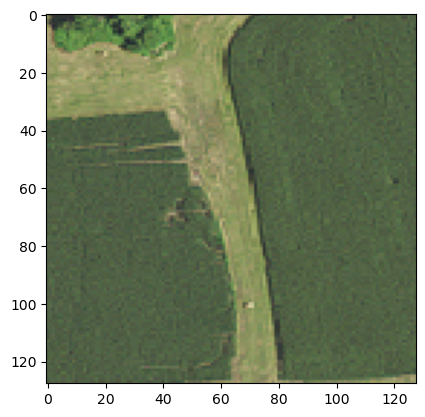

In [52]:
import matplotlib.pyplot as plt



plt.imshow(batch[0][4][2].numpy().transpose(1,2,0))

In [76]:
for batch in dataloader:
    
#     if torch.sum(batch[3]) != 10:
        
    print(batch[3])

tensor([0., 0., 1., 1., 1., 0., 0., 1., 1., 1.])
tensor([0., 0., 0., 1., 1., 0., 1., 1., 1., 1.])
tensor([1., 0., 1., 1., 0., 0., 1., 0., 1., 0.])
tensor([1., 1., 1., 1., 1., 0., 1., 1., 0., 0.])
tensor([1., 1., 0., 1., 0., 1., 1., 1., 0., 0.])
tensor([0., 0., 1., 1., 1., 1., 0., 0., 0., 0.])
tensor([1., 1., 1., 1., 0., 1., 1., 0., 1., 1.])
tensor([0., 1., 0., 0., 0., 1., 1., 1., 0., 0.])
tensor([1., 1., 1., 1., 0., 1., 1., 0., 0., 0.])
tensor([0., 1., 1., 0., 0., 0., 0., 1., 0., 1.])
tensor([0., 0., 1., 1., 0., 1., 0., 0., 1., 0.])


KeyboardInterrupt: 

AttributeError: 'ResNetFeatures' object has no attribute 'features'

In [145]:
full_dataset = SixImageDataset_DEM_GT(pos_dir, 
                                 neg_dir, 
                                 pos_dem_dir,
                                 neg_dem_dir,
                                 pos_gt_mask_dir,
                                 neg_gt_mask_dir,
                                 transform=transform)

# Splitting the dataset into train and validation sets
total_size = len(full_dataset)
val_size = int(0.2 * total_size)  # Let's use 20% of the dataset for validation
train_size = total_size - val_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoader setup
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=8)


In [146]:
image,_,_, label = next(iter(val_loader))

In [147]:
image.shape

AttributeError: 'list' object has no attribute 'shape'

In [161]:
from tqdm import tqdm

# Model initialization
pretrained_model_path = '/home/macula/SMATousi/cluster/docker-images/dem2so_more_data/pre_models/B3_rn50_moco_0099_ckpt.pth'

# model = gully_detector(resnet_output_size=(7, 7), 
#                       model_choice='dense_net', 
#                       resnet_saved_model_path=pretrained_model_path)

resnet_extractor = ResNetFeatureExtractor()
mlp_classifier = MLPClassifier(input_size=6*2048, hidden_size=512, output_size=1)

# Load the pre-trained weights
# print(torch.load(pretrained_model_path))
# resnet_extractor.load_state_dict(torch.load(pretrained_model_path), strict=False)


In [163]:


model.train()

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    for images, dem_images, gt_masks, labels in tqdm(dataloader):
        optimizer.zero_grad()
        features = [resnet_extractor(image) for image in images]
        stacked_features = torch.stack(features, dim=1)
        output = mlp_classifier(stacked_features)

        loss = criterion(output.squeeze(), labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def validate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, dem_images, gt_masks, labels in tqdm(dataloader):
            features = [resnet_extractor(image) for image in images]
            stacked_features = torch.stack(features, dim=1)
            output = mlp_classifier(stacked_features)

            loss = criterion(output.squeeze(), labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    return total_loss / len(dataloader)

num_epochs = 10
# Assume model, criterion, and optimizer are already defined
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss = validate(model, val_loader, criterion)
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Validation Loss = {val_loss:.4f}")

  2%|█▋                                                                                                         | 14/904 [00:16<17:09,  1.16s/it]


KeyboardInterrupt: 

In [162]:

model.train()
total_loss = 0
for images, dem_images, gt_masks, labels in tqdm(train_loader):
    optimizer.zero_grad()
    features = [resnet_extractor(image) for image in images]
    stacked_features = torch.stack(features, dim=1)
    output = mlp_classifier(stacked_features)

    loss = criterion(output.squeeze(), labels)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
return total_loss / len(dataloader)

  1%|█▏                                                                                                         | 10/904 [00:13<20:17,  1.36s/it]


KeyboardInterrupt: 

In [125]:
16384/8

2048.0

In [26]:
def calculate_metrics(labels, predictions):
    """Compute precision, recall, and F1 score."""
    precision = precision_score(labels, predictions, average='binary')
    recall = recall_score(labels, predictions, average='binary')
    f1 = f1_score(labels, predictions, average='binary')
    return precision, recall, f1

def evaluate_model(model, dataloader, criterion):
    """Evaluate model on a given dataloader and calculate loss and metrics."""
    model.eval()
    total_loss = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            outputs = model(images).squeeze(1)  # Assuming binary classification output
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            predicted_labels = (outputs > 0.5).float()  # Convert to binary predictions
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted_labels.cpu().numpy())

    precision, recall, f1 = calculate_metrics(all_labels, all_predictions)
    return total_loss / len(dataloader), precision, recall, f1

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for images, labels in tqdm(train_loader):
            optimizer.zero_grad()
            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Evaluate on training and validation sets
        train_loss, train_precision, train_recall, train_f1 = evaluate_model(model, train_loader, criterion)
        val_loss, val_precision, val_recall, val_f1 = evaluate_model(model, val_loader, criterion)

        # Logging metrics
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train - Loss: {train_loss:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")
        print(f"Val - Loss: {val_loss:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

# Example usage (assuming model, optimizer, criterion, train_loader, and val_loader are defined)
num_epochs = 10
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:04<00:00,  9.35it/s]


Epoch 1/10
Train - Loss: 0.6930, Precision: 0.5031, Recall: 1.0000, F1: 0.6695
Val - Loss: 0.6933, Precision: 0.4737, Recall: 0.9474, F1: 0.6316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:04<00:00,  9.18it/s]


Epoch 2/10
Train - Loss: 0.6926, Precision: 0.5031, Recall: 1.0000, F1: 0.6695
Val - Loss: 0.6927, Precision: 0.4737, Recall: 0.9474, F1: 0.6316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:04<00:00,  8.58it/s]


Epoch 3/10
Train - Loss: 0.6928, Precision: 0.5031, Recall: 1.0000, F1: 0.6695
Val - Loss: 0.6931, Precision: 0.4737, Recall: 0.9474, F1: 0.6316


 60%|████████████████████████████████████████████████████████████████▊                                           | 12/20 [00:14<00:09,  1.24s/it]


KeyboardInterrupt: 

1572864

In [29]:
model.eval()
# summary(model)

# Export the model as ONNX
torch_input = torch.randn(1, 6, 3, 128, 128)
torch.onnx.export(model, torch_input, "mnist_cnn.onnx", export_params=True, input_names=["input"], output_names=["output"])
    
    

/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/ipykernel_launcher.py:48: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/ipykernel_launcher.py:50: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/ipykernel_launcher.py:35: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the

torch.Size([6, 2048, 4, 4])
torch.Size([196608])


In [72]:
image_features = [torch.randn(1, 2048, 7, 7) for _ in range(6)]

# Squeeze batch dimension if your batch size is indeed 1, resulting in [2048, 7, 7]
squeezed_features = [features.squeeze(0) for features in image_features]

# Concatenate along a new dimension (first dimension after batch), resulting in [6, 2048, 7, 7]
concatenated_features = torch.stack(squeezed_features, dim=1)

# If you have a real batch size greater than 1, you should concatenate along the second dimension
# concatenated_features = torch.cat(squeezed_features, dim=1) if your inputs are already squeezed

print(concatenated_features.shape) 

torch.Size([2048, 6, 7, 7])


In [100]:
602112/6

100352.0